# 1. Imports & Station List

In [62]:
import pandas as pd
import numpy as np
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [63]:
TARGET_STATIONS = [
    "MIT at Mass Ave / Amherst St",
    "Central Square at Mass Ave / Essex St",
    "MIT Pacific St at Purrington St",
    "Harvard Square at Mass Ave / Dunster St",
    "Boylston St at Massachusetts Ave",
    "Charles St at Cambridge St",
    "Forsyth St at Huntington Ave",
    "Boylston St at Fairfield St",
    "Christian Science Plaza - Massachusetts Ave at Westland Ave",
    "MIT Stata Center at Vassar St / Main St",
]


# 2. Load the data

In [ ]:
# ---------------------------------------------------------
# 1. LOAD 12 MONTHS OF BLUEBIKES TRIP DATA
# ---------------------------------------------------------

tripdata_path = "data/2024_data/"  

all_files = glob.glob(tripdata_path + "2024*-bluebikes-tripdata.csv")

print("Files detected:")
for f in all_files:
    print(f)

df_list = []
for filename in all_files:
    print("Loading:", filename)
    df_month = pd.read_csv(filename)
    df_list.append(df_month)

rides = pd.concat(df_list, ignore_index=True)
print("Total rows loaded:", len(rides))

Files detected:
2024_data/202407-bluebikes-tripdata.csv
2024_data/202409-bluebikes-tripdata.csv
2024_data/202403-bluebikes-tripdata.csv
2024_data/202404-bluebikes-tripdata.csv
2024_data/202405-bluebikes-tripdata.csv
2024_data/202402-bluebikes-tripdata.csv
2024_data/202408-bluebikes-tripdata.csv
2024_data/202401-bluebikes-tripdata.csv
2024_data/202406-bluebikes-tripdata.csv
2024_data/202410-bluebikes-tripdata.csv
2024_data/202411-bluebikes-tripdata.csv
2024_data/202412-bluebikes-tripdata.csv
Loading: 2024_data/202407-bluebikes-tripdata.csv
Loading: 2024_data/202409-bluebikes-tripdata.csv
Loading: 2024_data/202403-bluebikes-tripdata.csv
Loading: 2024_data/202404-bluebikes-tripdata.csv
Loading: 2024_data/202405-bluebikes-tripdata.csv
Loading: 2024_data/202402-bluebikes-tripdata.csv
Loading: 2024_data/202408-bluebikes-tripdata.csv
Loading: 2024_data/202401-bluebikes-tripdata.csv
Loading: 2024_data/202406-bluebikes-tripdata.csv
Loading: 2024_data/202410-bluebikes-tripdata.csv
Loading: 2024_

In [ ]:

# ---------------------------------------------------------
# 2. LOAD STATION FEATURE DATA (feature.csv)
# ---------------------------------------------------------

station_features = pd.read_csv("data/2024_data/feature.csv")   # <-- your uploaded file

# Rename columns to shorter / code-friendly names
station_features = station_features.rename(columns={
    "Station_id": "station_id",
    "Station_name": "station_name",
    "Station latitude": "station_lat",
    "Station longitude": "station_lng",
    "Distance to nearest subway stop (m)": "dist_subway_m",
    "Distance to nearest bus stop (m)": "dist_bus_m",
    "Distance to nearest university (m)": "dist_university_m",
    "Distance to nearest business district": "dist_business",
    "Distance to nearest residential area": "dist_residential",
    "Population density around station": "pop_density",
    "Employment density around station": "emp_density",
    "Number of restaurants/cafes nearby": "restaurant_count",
    "Restaurant/cafes density around station": "restaurant_density",
})

# This file is purely station-level (no time info), so we just keep the static columns.
station_features = station_features[[
    "station_name",
    "station_lat",
    "station_lng",
    "dist_subway_m",
    "dist_bus_m",
    "dist_university_m",
    "dist_business",
    "dist_residential",
    "pop_density",
    "emp_density",
    "restaurant_count",
    "restaurant_density",
]]


## 2.1 Build hourly inflow / outflow per station

In [66]:
rides["started_at"] = pd.to_datetime(rides["started_at"], format="mixed")
rides["ended_at"] = pd.to_datetime(rides["ended_at"], format="mixed")


# Floor to hour for aggregation
rides["start_hour"] = rides["started_at"].dt.floor("H")
rides["end_hour"] = rides["ended_at"].dt.floor("H")

# Outflow: bikes leaving the station
out_df = (
    rides[rides["start_station_name"].isin(TARGET_STATIONS)]
    .groupby(["start_station_name", "start_hour"])
    .size()
    .reset_index(name="out_count")
    .rename(columns={"start_station_name": "station_name",
                     "start_hour": "hour"})
)

# Inflow: bikes arriving at the station
in_df = (
    rides[rides["end_station_name"].isin(TARGET_STATIONS)]
    .groupby(["end_station_name", "end_hour"])
    .size()
    .reset_index(name="in_count")
    .rename(columns={"end_station_name": "station_name",
                     "end_hour": "hour"})
)

# Merge inflow & outflow into one panel
panel = pd.merge(
    out_df,
    in_df,
    how="outer",
    on=["station_name", "hour"]
)

# Replace NaNs with 0 (no trips that hour)
panel[["in_count", "out_count"]] = panel[["in_count", "out_count"]].fillna(0).astype(int)

panel.head()


/var/folders/qd/ryt2vxzx55vckk3tg4kwwx_40000gn/T/ipykernel_58493/3698921882.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rides["start_hour"] = rides["started_at"].dt.floor("H")
/var/folders/qd/ryt2vxzx55vckk3tg4kwwx_40000gn/T/ipykernel_58493/3698921882.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rides["end_hour"] = rides["ended_at"].dt.floor("H")


,station_name,hour,out_count,in_count
0,Boylston St at Fairfield St,2024-01-01 00:00:00,2,0
1,Boylston St at Fairfield St,2024-01-01 01:00:00,3,1
2,Boylston St at Fairfield St,2024-01-01 02:00:00,2,0
3,Boylston St at Fairfield St,2024-01-01 07:00:00,0,1
4,Boylston St at Fairfield St,2024-01-01 11:00:00,0,1


## 2.2 Merge with station-level features

In [67]:
# Keep only the columns you really want from station_features
station_features_clean = station_features[[
    "station_name",
    "station_lat",
    "station_lng",
    "dist_subway_m",
    "dist_bus_m",
    "dist_university_m",
    "dist_business",
    "dist_residential",
    "pop_density",
    "emp_density",
    "restaurant_count",
    "restaurant_density",
]]

# Merge
panel = panel.merge(
    station_features_clean,
    on="station_name",
    how="left"
)

#Time-based features
panel["month"] = panel["hour"].dt.month
panel["day_of_week"] = panel["hour"].dt.dayofweek    # 0 = Monday
panel["hour_of_day"] = panel["hour"].dt.hour
panel["is_weekend"] = panel["day_of_week"].isin([5, 6]).astype(int)  # Sat/Sun



panel.head()


,station_name,hour,out_count,in_count,station_lat,station_lng,dist_subway_m,dist_bus_m,dist_university_m,dist_business,dist_residential,pop_density,emp_density,restaurant_count,restaurant_density,month,day_of_week,hour_of_day,is_weekend
0,Boylston St at Fairfield St,2024-01-01 00:00:00,2,0,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,0,0
1,Boylston St at Fairfield St,2024-01-01 01:00:00,3,1,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,1,0
2,Boylston St at Fairfield St,2024-01-01 02:00:00,2,0,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,2,0
3,Boylston St at Fairfield St,2024-01-01 07:00:00,0,1,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,7,0
4,Boylston St at Fairfield St,2024-01-01 11:00:00,0,1,42.348,-71.0824,276.328,71.401,283.066,1.629905,0.352641,High,High,110.0,Very High,1,0,11,0


In [68]:
station_features.columns.tolist()

['station_name',
 'station_lat',
 'station_lng',
 'dist_subway_m',
 'dist_bus_m',
 'dist_university_m',
 'dist_business',
 'dist_residential',
 'pop_density',
 'emp_density',
 'restaurant_count',
 'restaurant_density']

In [69]:
# Feature columns
numeric_features = [
    "hour_of_day",
    "day_of_week",
    "month",
    "is_weekend",
    "station_lat",
    "station_lng",
    "dist_subway_m",
    "dist_bus_m",
    "dist_university_m",
    "dist_business",
    "dist_residential",
    "restaurant_count",
]

X = panel[numeric_features].copy()


# 3.Train / test split

In [81]:
# ---------------------------------------------------------
# 1. Extract target variables
# ---------------------------------------------------------
y_out = panel["out_count"].values   # shape (n_samples,)
y_in  = panel["in_count"].values    # shape (n_samples,)

# ---------------------------------------------------------
# 2. Combine out & in into ONE target matrix
#    Y[:,0] = out_count
#    Y[:,1] = in_count
# ---------------------------------------------------------
Y = np.column_stack([y_out, y_in])   # shape (n_samples, 2)

# ---------------------------------------------------------
# 3. Train-Test Split (same split for both outputs)
# ---------------------------------------------------------
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------
# 4. Extract individual outputs after split
# ---------------------------------------------------------
y_train_out = Y_train[:, 0]
y_train_in  = Y_train[:, 1]

y_test_out  = Y_test[:, 0]
y_test_in   = Y_test[:, 1]

print("Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Shapes:
X_train: (46598, 12)
Y_train: (46598, 2)
X_test: (11650, 12)
Y_test: (11650, 2)


# 4. Fit the model and evaluate

In [88]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor

# Metrics
def print_regression_metrics(split, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"=== {split} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")


alphas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 5]

for a in alphas:
    print(f"\n====== Alpha = {a} ======")

    clf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("poisson", PoissonRegressor(alpha=a, max_iter=1000))
    ])


    # Fit
    clf.fit(X_train, y_train_in)

    # Predict
    y_train_pred = clf.predict(X_train)
    y_test_pred  = clf.predict(X_test)


    print_regression_metrics("TRAIN", y_train_in, y_train_pred)
    print_regression_metrics("TEST", y_test_in, y_test_pred)



====== Alpha = 0.0001 ======
=== TRAIN ===
MAE:  4.491
RMSE: 6.018
=== TEST ===
MAE:  4.479
RMSE: 5.998

====== Alpha = 0.001 ======
=== TRAIN ===
MAE:  4.491
RMSE: 6.018
=== TEST ===
MAE:  4.479
RMSE: 5.998

====== Alpha = 0.01 ======
=== TRAIN ===
MAE:  4.491
RMSE: 6.017
=== TEST ===
MAE:  4.479
RMSE: 5.998

====== Alpha = 0.1 ======
=== TRAIN ===
MAE:  4.493
RMSE: 6.016
=== TEST ===
MAE:  4.480
RMSE: 5.997

====== Alpha = 0.5 ======
=== TRAIN ===
MAE:  4.505
RMSE: 6.019
=== TEST ===
MAE:  4.493
RMSE: 6.003

====== Alpha = 1 ======
=== TRAIN ===
MAE:  4.520
RMSE: 6.028
=== TEST ===
MAE:  4.510
RMSE: 6.014

====== Alpha = 5 ======
=== TRAIN ===
MAE:  4.608
RMSE: 6.120
=== TEST ===
MAE:  4.603
RMSE: 6.109


In [97]:
proportions = pd.Series(panel["in_count"]).value_counts(normalize=True).sort_index()

print(proportions)


in_count
0     0.078595
1     0.133309
2     0.094235
3     0.081462
4     0.071951
5     0.068363
6     0.061564
7     0.055985
8     0.049839
9     0.044826
10    0.036705
11    0.033220
12    0.027246
13    0.023640
14    0.021649
15    0.016910
16    0.014644
17    0.012601
18    0.010627
19    0.008927
20    0.007314
21    0.006867
22    0.005528
23    0.005082
24    0.004155
25    0.004000
26    0.003056
27    0.002575
28    0.002335
29    0.002129
30    0.001665
31    0.001047
32    0.001219
33    0.001082
34    0.000858
35    0.000790
36    0.000755
37    0.000464
38    0.000549
39    0.000275
40    0.000361
41    0.000309
42    0.000155
43    0.000240
44    0.000258
45    0.000120
46    0.000137
47    0.000086
48    0.000052
49    0.000034
50    0.000052
51    0.000034
52    0.000017
55    0.000017
56    0.000034
57    0.000034
60    0.000017
Name: proportion, dtype: float64


In [98]:
vals = pd.Series(y_train_in)
print("Mean:", vals.mean())
print("Variance:", vals.var())


Mean: 6.873835786943646
Variance: 43.758338103127706


# 5. Performance Measurement

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ---- choose your demand threshold for classification ----
threshold = 1

# convert to binary classes
y_train_true_bin = (y_train_in >= threshold).astype(int)
y_train_pred_bin = (y_train_pred >= threshold).astype(int)

y_test_true_bin  = (y_test_in >= threshold).astype(int)
y_test_pred_bin  = (y_test_pred >= threshold).astype(int)


In [59]:
from sklearn.metrics import f1_score

best_f1 = 0
best_t = None

for t in range(1, 40):
    pred_bin = (y_test_pred >= t).astype(int)
    f1 = f1_score(y_test_true_bin, pred_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)


Best threshold: 1
Best F1: 0.9591709103904226


In [60]:
def print_classification_metrics(split, y_true, y_pred):
    print(f"\n=== {split} — Classification Metrics ===")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))

print_classification_metrics("TRAIN", y_train_true_bin, y_train_pred_bin)
print_classification_metrics("TEST", y_test_true_bin, y_test_pred_bin)



=== TRAIN — Classification Metrics ===
Precision: 0.9213700158805099
Recall:    1.0
F1 Score:  0.9590760845284367

=== TEST — Classification Metrics ===
Precision: 0.9215450643776824
Recall:    1.0
F1 Score:  0.9591709103904226


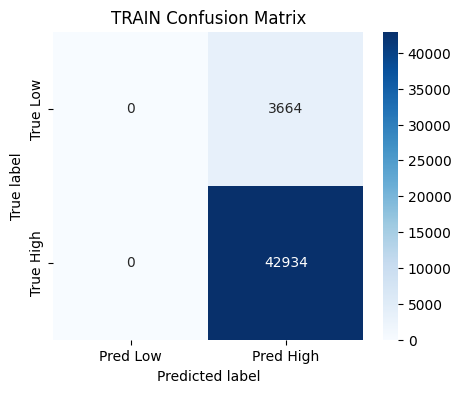

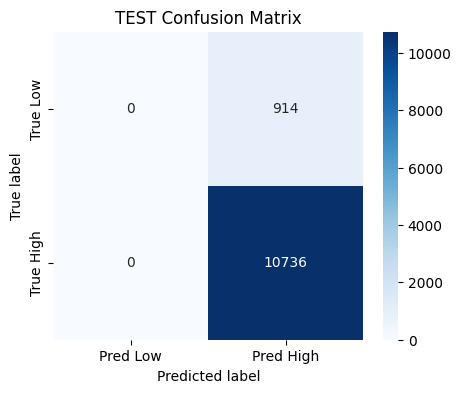

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion(split, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred Low", "Pred High"],
                yticklabels=["True Low", "True High"])
    plt.title(f"{split} Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

plot_confusion("TRAIN", y_train_true_bin, y_train_pred_bin)
plot_confusion("TEST", y_test_true_bin, y_test_pred_bin)
